In [1]:
import torch
import pdb
from torch import nn
import torch.nn.functional as f
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels,out_channels,strides=2,downsample=False):
        super(ResNetBlock, self).__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels,out_channels,stride=strides,kernel_size=3,padding=1,bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels,out_channels,stride=strides,kernel_size=1,padding=0,bias=False)
        
    def forward(self,x):
        residual = x
        x = f.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.downsample == True:
            residual = self.bn2(self.conv3(residual))
        x = x + residual
        x = f.relu(x)
        return x

In [3]:
# check resnet block
# net = ResNetBlock(32,64,downsample=True)

In [4]:
# net.to('cuda')
# summary(net,input_size=(32,224,224))

In [5]:
class ResNet(nn.Module):
    def __init__(self,in_channels,base_channels,output,block):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,base_channels,stride=2,kernel_size=7,padding=3,bias=False)
        self.bn1   = nn.BatchNorm2d(base_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.layer1  = self._make_layer(block,3,False,base_channels,base_channels)
        self.layer2  = self._make_layer(block,4,True,base_channels,base_channels*2)
        self.layer3  = self._make_layer(block,6,True,base_channels*2,base_channels*4)
        self.layer4  = self._make_layer(block,3,True,base_channels*4,base_channels*8)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dense   = nn.Linear(base_channels*8,output)
    
    def _make_layer(self,block,no_layer,downsample,in_channels,out_channels):
        layers = []
        if downsample == True:
            layers.append(block(in_channels,out_channels,downsample=True))
        else:
            layers.append(block(in_channels,out_channels,strides=1))
            
        for _ in range(no_layer-1):
            layers.append(block(out_channels,out_channels,strides=1))
            
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = f.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = f.relu(self.dense(x))
        return x

In [13]:
net = ResNet(3,64,1000,ResNetBlock)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)

In [7]:
# net.to('cuda')
# summary(net,input_size=(3,32,32))

In [8]:
def load_data():
    transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    train = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
    train = torch.utils.data.DataLoader(train,batch_size=256,shuffle=True)
    test = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
    test = torch.utils.data.DataLoader(test,batch_size=256,shuffle=False)
    return train,test

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
train, test = load_data()

Files already downloaded and verified
Files already downloaded and verified


In [9]:
costFunction = torch.nn.CrossEntropyLoss()
optimizer    = torch.optim.SGD(net.parameters(),lr=0.001, momentum=0.9, weight_decay=5e-4)

In [10]:
def train_model(epochs):
    net.train()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    for epoch in range(epochs):
        total_loss = 0
        losses = []
        for i,(x,y) in enumerate(train,0):
            x,y = x.to(device), y.to(device)
            prediction = net(x)
            loss = costFunction(prediction, y)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i%9==0:
                losses.append(loss.item())
            if i%99 == 0:
                print('[%d %d] loss: %.4f'%(epoch+1,i,total_loss/1000))
                total_loss=0
        accuracy()
        plt.plot(losses,label='epoch'+str(epoch))
        plt.legend(loc=1,mode='expanded',shadow=True,ncol=2)
    plt.show()

In [11]:
def accuracy():
    net.eval()
    correct=0
    total=0
    accuracy=0
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    for (x,y) in test:
        x,y = x.to(device), y.to(device)
        prediction = net(x)
        _, prediction = torch.max(prediction.data,1)
        total += y.size(0)
        correct += (prediction==y).sum().item()
        accuracy = (correct/total)*100
        
    print('Accuracy on test ' + str(accuracy))

[1 1] loss: 0.0072
[1 101] loss: 0.2742
Accuracy on test 34.28
[2 1] loss: 0.0018
[2 101] loss: 0.1604
Accuracy on test 46.56
[3 1] loss: 0.0015
[3 101] loss: 0.1423
Accuracy on test 49.220000000000006
[4 1] loss: 0.0015
[4 101] loss: 0.1320
Accuracy on test 53.97
[5 1] loss: 0.0013
[5 101] loss: 0.1244
Accuracy on test 55.24


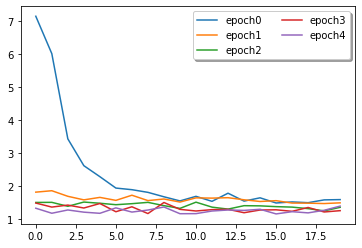

In [12]:
train_model(5)